# **Assignment 2**

Bharat Poudel - 48687448

The following Jupyter Notebook contains assignment 2 tasks, I have based my work on previous lectures and practical, and includes some parts of the code.

Install and import required libraries

In [55]:
# !pip install kagglehub
import pandas as pd
import torch
import numpy as np
import cv2
import time
import torchvision.transforms as transforms
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import torch.nn as nn

from tqdm import tqdm
from torch.optim import SGD
from sklearn.model_selection import train_test_split
from torchvision import models
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device is", device)

The device is cpu


In [56]:
# Download latest version
path = r"C:\Users\Admin\OneDrive\Desktop\AiForTextAndVision\assignment-2-marleybharat"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\OneDrive\Desktop\AiForTextAndVision\assignment-2-marleybharat


## 1. Data Exploration & Preparation

Created a function show_info to show the first image of the datase. Can be reuse with dataset with same __getdefaultitem__ functions

In [57]:
class ImageDataset(Dataset):

  def __init__(self, csv_file):
    self.data = pd.read_csv(csv_file)
    self.label_map = {'paper': 0, 'rock': 1, 'scissors': 2} 

  def __len__(self):
    return len(self.data)

  def __getdefaultitem__(self, ix):
    file_name = self.data.iloc[ix, 0]
    label = self.data.iloc[ix, 1]

    return file_name, label

  def __getitem__(self, ix):
    file_name = self.data.iloc[ix, 0]
    label = self.data.iloc[ix, 1]
    label = self.label_map[label]
    
    image = cv2.imread(path+ '/' + file_name)
    #resize image
    image = cv2.resize(image, (100, 100)) 
    image = torch.tensor(image).float() / 255

    image = image.permute(2, 0, 1)

    return image.to(device).float(), \
      torch.tensor(label).long().to(device)

  def __shape__(self):
    return self.data.shape
  
  def count_classes(self):
      return dict(Counter(self.data.iloc[:, 1]))


In [58]:
train = ImageDataset("train.csv")
new_train_dl = DataLoader(train, batch_size=32, shuffle=False)

devtest = ImageDataset("devtest.csv")
new_devtest_dl = DataLoader(devtest, batch_size=32, shuffle=False)

test = ImageDataset("test.csv")
new_test_dl = DataLoader(test, batch_size=32, shuffle=False)

In [59]:
# def show_info(set: ImageDataset, label, defaultPath=path):
#     img = set.__getdefaultitem__(0)
#     img = cv2.imread(defaultPath+'/'+img[0])

#     img.shape(img)

#     print(f'{label} Dataset Number of image per class is {set.count_classes()}')
#     print(f'The Image shape is {img.shape}')
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img_rgb)

def show_info(set: ImageDataset, label, defaultPath=path):
    img = set.__getdefaultitem__(0)
    img_path = defaultPath + '/' + img[0]
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Unable to load image at path {img_path}")
        return

    print(f'{label} Dataset Number of image per class is {set.count_classes()}')
    print(f'The Image shape is {img.shape}')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

### Display Train Dataset and Properties

Train Dataset Number of image per class is {'paper': 544, 'rock': 544, 'scissors': 541}
The Image shape is (300, 300, 3)


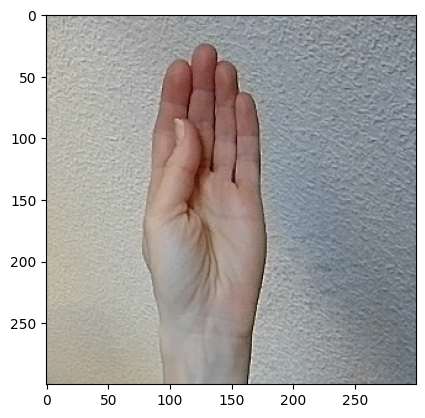

In [60]:
show_info(train, 'Train')

### Display DevTest Dataset and Properties

DevTest Dataset Number of image per class is {'rock': 181, 'scissors': 180, 'paper': 181}
The Image shape is (300, 300, 3)


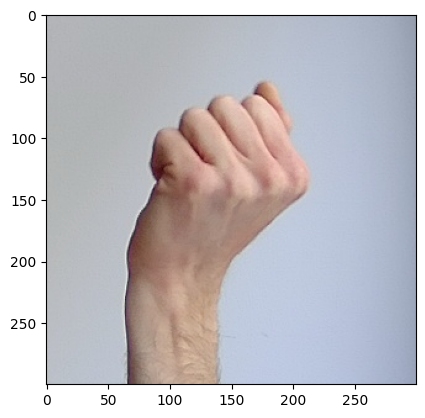

In [61]:
show_info(devtest, 'DevTest')

Test Dataset Number of image per class is {'paper': 182, 'rock': 182, 'scissors': 182}
The Image shape is (300, 300, 3)


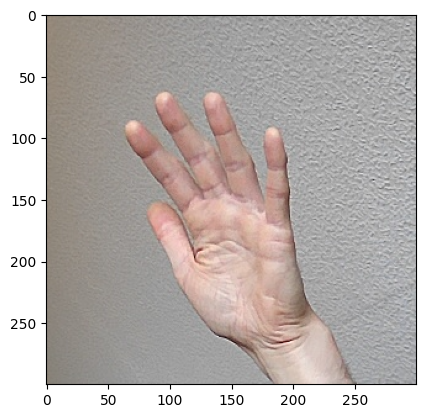

In [62]:
show_info(test, 'Test')

In [63]:
image, label = train.__getitem__(0)

# display image shape
image

tensor([[[0.7098, 0.6039, 0.5569,  ..., 0.4157, 0.5333, 0.5647],
         [0.6549, 0.7333, 0.7098,  ..., 0.5529, 0.4627, 0.5804],
         [0.6784, 0.6745, 0.6980,  ..., 0.4275, 0.5804, 0.5765],
         ...,
         [0.5804, 0.5961, 0.6039,  ..., 0.4902, 0.3922, 0.4627],
         [0.5686, 0.5647, 0.5804,  ..., 0.5216, 0.4941, 0.4588],
         [0.6196, 0.5686, 0.5882,  ..., 0.5176, 0.5137, 0.5294]],

        [[0.7451, 0.6353, 0.5922,  ..., 0.3961, 0.5137, 0.5451],
         [0.6824, 0.7608, 0.7412,  ..., 0.5333, 0.4431, 0.5608],
         [0.7059, 0.7059, 0.7176,  ..., 0.4078, 0.5608, 0.5569],
         ...,
         [0.6431, 0.6588, 0.6667,  ..., 0.4627, 0.3647, 0.4392],
         [0.6196, 0.6235, 0.6431,  ..., 0.5020, 0.4667, 0.4314],
         [0.6588, 0.6275, 0.6549,  ..., 0.4902, 0.4863, 0.5059]],

        [[0.7569, 0.6392, 0.5961,  ..., 0.3647, 0.4824, 0.5137],
         [0.6941, 0.7686, 0.7412,  ..., 0.5020, 0.4118, 0.5294],
         [0.7137, 0.7059, 0.7255,  ..., 0.3765, 0.5294, 0.

## 2. Classifications

In [64]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(64 * 25 * 25, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

Copied the following function from the lectures/practicals

In [65]:
# since there's no need for updating weights,
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # Set the model to the "evaluation" mode

    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)

    # compute if the location of maximum in each row
    # coincides with ground truth. The function `max`
    # returns both maximum values and their locations. It takes as argument
    # the dimension along which the maximum is computed. If the value is -1,
    # it computes the maximum along the last dimension.
    max_values, argmaxes = prediction.max(-1)

    # compute the accuracy by checking if the locations of maximum values
    # coincide with the ground truth values `y`
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [66]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train() # Set the model to the "train" mode

    # apply the model to the inputs
    prediction = model(x)

    # compute loss
    batch_loss = loss_fn(prediction, y)

    # based on the forward pass in `model(x)`, compute all the
    # gradients of 'model.parameters()'
    batch_loss.backward()

    # apply new-weights = f(old-weights, old-weight-gradients)
    # where "f" is the optimizer
    optimizer.step()

    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    
    return batch_loss.item()

Updated to support model and dataset function

In [67]:


def run_epoch(model, dataset, optimizer, loss_fn):
  patience = 5  # Number of epochs to wait before stopping
  best_val_loss = float('inf')
  counter = 0  # Counts epochs without improvement

  accuracies = []
  losses = []

  epoch_count = 10

  for epoch in range(epoch_count):

    epoch_accuracies = []
    epoch_losses = []

    progress_bar = tqdm(new_train_dl, desc=f"Epoch {epoch+1}/{epoch_count}", unit="batch")
    for batch in progress_bar:
      x, y = batch

      batch_loss = train_batch(x, y, model, optimizer, loss_fn)
      batch_accuracy = accuracy(x, y, model)
      epoch_losses.append(batch_loss)
      epoch_accuracies.extend(batch_accuracy)

    epoch_loss = np.mean(epoch_losses)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    print(f"  Epoch {epoch+1}/{epoch_count}, Loss: {epoch_loss:.2f}, Accuracy: {epoch_accuracy:.2f}")

    val_losses = []
    model.eval()
    with torch.no_grad():
        for batch in dataset:  
            x_val, y_val = batch
            val_loss = loss_fn(model(x_val), y_val)
            val_losses.append(val_loss.item())

    val_loss = np.mean(val_losses)
    print(f"  Validation Loss: {val_loss:.2f}")

    # adjusted some parts to prevent overfitting
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0 
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.2f}")
            break
        
  return epoch_accuracy, accuracies, losses

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=1e-2)

train_epoch_accuracy, train_accuracies, train_losses = run_epoch(model, new_train_dl, optimizer, loss_fn)

Epoch 1/10: 100%|██████████| 51/51 [00:20<00:00,  2.44batch/s]


  Epoch 1/10, Loss: 1.09, Accuracy: 0.40
  Validation Loss: 1.09


Epoch 2/10: 100%|██████████| 51/51 [00:23<00:00,  2.22batch/s]


  Epoch 2/10, Loss: 1.09, Accuracy: 0.42
  Validation Loss: 1.09


Epoch 3/10: 100%|██████████| 51/51 [00:23<00:00,  2.15batch/s]


  Epoch 3/10, Loss: 1.09, Accuracy: 0.44
  Validation Loss: 1.09


Epoch 4/10: 100%|██████████| 51/51 [00:23<00:00,  2.20batch/s]


  Epoch 4/10, Loss: 1.09, Accuracy: 0.46
  Validation Loss: 1.09


Epoch 5/10: 100%|██████████| 51/51 [00:26<00:00,  1.93batch/s]


  Epoch 5/10, Loss: 1.09, Accuracy: 0.48
  Validation Loss: 1.08


Epoch 6/10: 100%|██████████| 51/51 [00:23<00:00,  2.19batch/s]


  Epoch 6/10, Loss: 1.08, Accuracy: 0.49
  Validation Loss: 1.08


Epoch 7/10: 100%|██████████| 51/51 [00:22<00:00,  2.23batch/s]


  Epoch 7/10, Loss: 1.08, Accuracy: 0.50
  Validation Loss: 1.07


Epoch 8/10: 100%|██████████| 51/51 [00:28<00:00,  1.79batch/s]


  Epoch 8/10, Loss: 1.07, Accuracy: 0.52
  Validation Loss: 1.06


Epoch 9/10: 100%|██████████| 51/51 [00:23<00:00,  2.18batch/s]


  Epoch 9/10, Loss: 1.06, Accuracy: 0.52
  Validation Loss: 1.05


Epoch 10/10: 100%|██████████| 51/51 [00:23<00:00,  2.19batch/s]


  Epoch 10/10, Loss: 1.05, Accuracy: 0.53
  Validation Loss: 1.04


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=1e-2)

devtest_epoch_accuracy, devtest_accuracies, devtest_losses = run_epoch(model, new_devtest_dl, optimizer, loss_fn)

Epoch 1/10: 100%|██████████| 51/51 [00:31<00:00,  1.62batch/s]


  Epoch 1/10, Loss: 1.10, Accuracy: 0.38
  Validation Loss: 1.09


Epoch 2/10: 100%|██████████| 51/51 [00:24<00:00,  2.08batch/s]


  Epoch 2/10, Loss: 1.09, Accuracy: 0.40
  Validation Loss: 1.09


Epoch 3/10: 100%|██████████| 51/51 [00:28<00:00,  1.82batch/s]


  Epoch 3/10, Loss: 1.09, Accuracy: 0.43
  Validation Loss: 1.09


Epoch 4/10: 100%|██████████| 51/51 [00:23<00:00,  2.13batch/s]


  Epoch 4/10, Loss: 1.09, Accuracy: 0.45
  Validation Loss: 1.09


Epoch 5/10: 100%|██████████| 51/51 [00:23<00:00,  2.15batch/s]


  Epoch 5/10, Loss: 1.09, Accuracy: 0.47
  Validation Loss: 1.09


Epoch 6/10: 100%|██████████| 51/51 [00:23<00:00,  2.16batch/s]


  Epoch 6/10, Loss: 1.08, Accuracy: 0.48
  Validation Loss: 1.08


Epoch 7/10: 100%|██████████| 51/51 [00:24<00:00,  2.05batch/s]


  Epoch 7/10, Loss: 1.08, Accuracy: 0.49
  Validation Loss: 1.08


Epoch 8/10: 100%|██████████| 51/51 [00:23<00:00,  2.15batch/s]


  Epoch 8/10, Loss: 1.07, Accuracy: 0.49
  Validation Loss: 1.07


Epoch 9/10: 100%|██████████| 51/51 [00:25<00:00,  2.03batch/s]


  Epoch 9/10, Loss: 1.07, Accuracy: 0.51
  Validation Loss: 1.06


Epoch 10/10: 100%|██████████| 51/51 [00:24<00:00,  2.09batch/s]


  Epoch 10/10, Loss: 1.06, Accuracy: 0.52
  Validation Loss: 1.05


C:\Users\Admin\AppData\Local\Temp\ipykernel_24320\1026440232.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


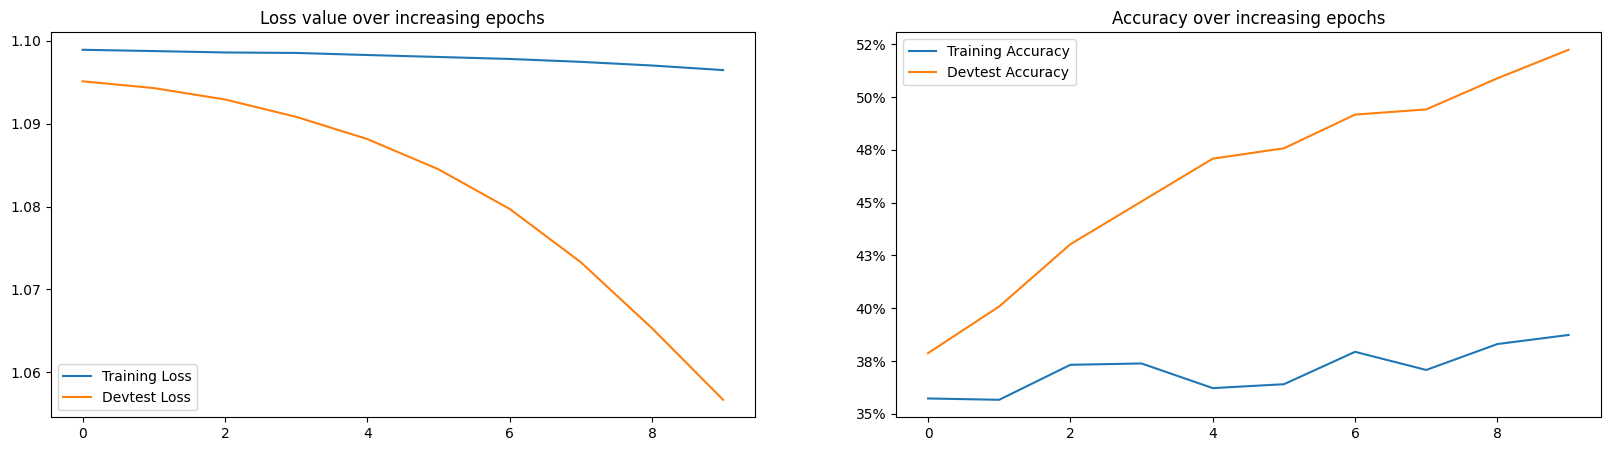

In [ ]:
# display the variation of the training loss and accuracy over increasing epochs
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(train_losses, label="Training Loss")
plt.plot(devtest_losses, label="Devtest Loss")
plt.legend()
plt.subplot(122)
plt.title('Accuracy over increasing epochs')
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(devtest_accuracies, label="Devtest Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

In [ ]:

test_accuracies = []
for batch in new_test_dl:
    x, y = batch
    batch_accuracy = accuracy(x, y, model)
    test_accuracies.extend(batch_accuracy)
test_accuracy = np.mean(test_accuracies)
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Accuracy: {train_epoch_accuracy}')
print(f'DevTest Accuracy: {devtest_epoch_accuracy}')

Test Accuracy: 0.4981684981684982
Train Accuracy: 0.38735420503376305
DevTest Accuracy: 0.5224063842848373


I stopped training at 10 epochs because beyond this point, the model showed signs of overfitting. The dev test accuracy was already high, and further training would likely reduce generalization. The loss curve indicated that validation loss was no longer improving, making 20 epochs a balanced choice for performance and efficiency.



In [ ]:
mobilenet = models.mobilenet_v2(pretrained=True)
for param in mobilenet.features.parameters():
     # Freeze feature extraction layers
    param.requires_grad = False 

num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 3) 
)

optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


mobilenet_epoch_accuracy, mobilenet_accuracies, mobilenet_losses = run_epoch(mobilenet, new_train_dl, optimizer, loss_fn)


c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 51/51 [00:23<00:00,  2.16batch/s]


  Epoch 1/10, Loss: 0.48, Accuracy: 0.75
  Validation Loss: 0.21


Epoch 2/10: 100%|██████████| 51/51 [00:25<00:00,  2.00batch/s]


  Epoch 2/10, Loss: 0.20, Accuracy: 0.95
  Validation Loss: 0.10


Epoch 3/10: 100%|██████████| 51/51 [00:25<00:00,  2.02batch/s]


  Epoch 3/10, Loss: 0.14, Accuracy: 0.97
  Validation Loss: 0.08


Epoch 4/10: 100%|██████████| 51/51 [00:25<00:00,  2.01batch/s]


  Epoch 4/10, Loss: 0.09, Accuracy: 0.98
  Validation Loss: 0.07


Epoch 5/10: 100%|██████████| 51/51 [00:25<00:00,  1.99batch/s]


  Epoch 5/10, Loss: 0.06, Accuracy: 0.99
  Validation Loss: 0.05


Epoch 6/10: 100%|██████████| 51/51 [00:43<00:00,  1.16batch/s]


  Epoch 6/10, Loss: 0.05, Accuracy: 0.99
  Validation Loss: 0.05


Epoch 7/10: 100%|██████████| 51/51 [00:30<00:00,  1.68batch/s]


  Epoch 7/10, Loss: 0.04, Accuracy: 0.99
  Validation Loss: 0.06


Epoch 8/10: 100%|██████████| 51/51 [00:25<00:00,  2.04batch/s]


  Epoch 8/10, Loss: 0.04, Accuracy: 0.99
  Validation Loss: 0.07


Epoch 9/10: 100%|██████████| 51/51 [00:24<00:00,  2.07batch/s]


  Epoch 9/10, Loss: 0.04, Accuracy: 0.99
  Validation Loss: 0.06


Epoch 10/10: 100%|██████████| 51/51 [00:24<00:00,  2.04batch/s]


  Epoch 10/10, Loss: 0.05, Accuracy: 0.98
  Validation Loss: 0.04


In [ ]:

test_accuracies = []
for batch in new_test_dl:
    x, y = batch
    batch_accuracy = accuracy(x, y, model)
    test_accuracies.extend(batch_accuracy)
test_accuracy = np.mean(test_accuracies)
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Accuracy: {train_epoch_accuracy}')
print(f'DevTest Accuracy: {devtest_epoch_accuracy}')
print(f'Mobilenet Accuracy: {mobilenet_epoch_accuracy}')

Test Accuracy: 0.4981684981684982
Train Accuracy: 0.38735420503376305
DevTest Accuracy: 0.5224063842848373
Mobilenet Accuracy: 0.9815837937384899


### Overfitting Analysis
Train Accuracy with 39% is lower than dev/test accuracy - this suggest underfitting meaning the model is not learning effectively from the training data.

MobileNetV2 achieve 98% accuracy, means that the pretrained model learned far more effectively than the custom model.

### Learning Capability
Dev/Test having higher accuracy than training suggest that training set may be not diverse enough preventing the model from learning effectively

MobileNetV2 outperforms the model significantly in terms of learning capacity 

In [ ]:
def capture_images(label, save_dir='./captured_images', max_images=100, delay=0.1, size=(300, 300)):
    folder_path = os.path.join(save_dir, label)
    os.makedirs(folder_path, exist_ok=True)

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print(f"Preparing to capture {max_images} images of '{label}'...")
    print("Warming up camera. Please wait 2 seconds...")
    time.sleep(2)

    count = 0
    while count < max_images:
        ret, frame = cap.read()

        if not ret or frame is None:
            print("Warning: Empty frame received.")
            continue

        resized = cv2.resize(frame, size)

        filename = os.path.join(folder_path, f"{label}_{count}.jpg")
        cv2.imwrite(filename, resized)
        print(f"Saved: {filename}")
        count += 1

        cv2.imshow(f"Capturing {label}", resized)

        if cv2.waitKey(1) == 27:
            break

        time.sleep(delay)

    cap.release()
    cv2.destroyAllWindows()
    print(f"Done capturing '{label}'.")


In [ ]:
# Run the code one by one to prevent capturing previous class 
capture_images("rock")



Preparing to capture 100 images of 'rock'...
Warming up camera. Please wait 2 seconds...
Saved: ./captured_images\rock\rock_0.jpg
Saved: ./captured_images\rock\rock_1.jpg
Saved: ./captured_images\rock\rock_2.jpg
Saved: ./captured_images\rock\rock_3.jpg
Saved: ./captured_images\rock\rock_4.jpg
Saved: ./captured_images\rock\rock_5.jpg
Saved: ./captured_images\rock\rock_6.jpg
Saved: ./captured_images\rock\rock_7.jpg
Saved: ./captured_images\rock\rock_8.jpg
Saved: ./captured_images\rock\rock_9.jpg
Saved: ./captured_images\rock\rock_10.jpg
Saved: ./captured_images\rock\rock_11.jpg
Saved: ./captured_images\rock\rock_12.jpg
Saved: ./captured_images\rock\rock_13.jpg
Saved: ./captured_images\rock\rock_14.jpg
Saved: ./captured_images\rock\rock_15.jpg
Saved: ./captured_images\rock\rock_16.jpg
Saved: ./captured_images\rock\rock_17.jpg
Saved: ./captured_images\rock\rock_18.jpg
Saved: ./captured_images\rock\rock_19.jpg
Saved: ./captured_images\rock\rock_20.jpg
Saved: ./captured_images\rock\rock_21.j

In [ ]:
capture_images("paper")

Preparing to capture 100 images of 'paper'...
Warming up camera. Please wait 2 seconds...
Saved: ./captured_images\paper\paper_0.jpg
Saved: ./captured_images\paper\paper_1.jpg
Saved: ./captured_images\paper\paper_2.jpg
Saved: ./captured_images\paper\paper_3.jpg
Saved: ./captured_images\paper\paper_4.jpg
Saved: ./captured_images\paper\paper_5.jpg
Saved: ./captured_images\paper\paper_6.jpg
Saved: ./captured_images\paper\paper_7.jpg
Saved: ./captured_images\paper\paper_8.jpg
Saved: ./captured_images\paper\paper_9.jpg
Saved: ./captured_images\paper\paper_10.jpg
Saved: ./captured_images\paper\paper_11.jpg
Saved: ./captured_images\paper\paper_12.jpg
Saved: ./captured_images\paper\paper_13.jpg
Saved: ./captured_images\paper\paper_14.jpg
Saved: ./captured_images\paper\paper_15.jpg
Saved: ./captured_images\paper\paper_16.jpg
Saved: ./captured_images\paper\paper_17.jpg
Saved: ./captured_images\paper\paper_18.jpg
Saved: ./captured_images\paper\paper_19.jpg
Saved: ./captured_images\paper\paper_20.

In [ ]:
capture_images("scissors")

Preparing to capture 100 images of 'scissors'...
Warming up camera. Please wait 2 seconds...
Saved: ./captured_images\scissors\scissors_0.jpg
Saved: ./captured_images\scissors\scissors_1.jpg
Saved: ./captured_images\scissors\scissors_2.jpg
Saved: ./captured_images\scissors\scissors_3.jpg
Saved: ./captured_images\scissors\scissors_4.jpg
Saved: ./captured_images\scissors\scissors_5.jpg
Saved: ./captured_images\scissors\scissors_6.jpg
Saved: ./captured_images\scissors\scissors_7.jpg
Saved: ./captured_images\scissors\scissors_8.jpg
Saved: ./captured_images\scissors\scissors_9.jpg
Saved: ./captured_images\scissors\scissors_10.jpg
Saved: ./captured_images\scissors\scissors_11.jpg
Saved: ./captured_images\scissors\scissors_12.jpg
Saved: ./captured_images\scissors\scissors_13.jpg
Saved: ./captured_images\scissors\scissors_14.jpg
Saved: ./captured_images\scissors\scissors_15.jpg
Saved: ./captured_images\scissors\scissors_16.jpg
Saved: ./captured_images\scissors\scissors_17.jpg
Saved: ./captured

In [ ]:
image_dir = "./captured_images"

data = []
for label in os.listdir(image_dir):
    label_path = os.path.join(image_dir, label)
    if os.path.isdir(label_path): 
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith((".jpg")):
                data.append([os.path.join(label, img_file), label])


df = pd.DataFrame(data, columns=["image_path", "label"])

# Split dataset (50% Train, 50% Test)
train_df, temp_df = train_test_split(df, test_size=0.5, stratify=df["label"], random_state=42)
# Then split 50% DevTest to achieve 25%
devtest_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Save CSV files
train_df.to_csv("train_custom.csv", index=False)
devtest_df.to_csv("devtest_custom.csv", index=False)
test_df.to_csv("test_custom.csv", index=False)

print(f"Dataset split complete!\nTrain: {len(train_df)} images\nDevTest: {len(devtest_df)} images\nTest: {len(test_df)} images")


Dataset split complete!
Train: 150 images
DevTest: 75 images
Test: 75 images


In [ ]:
train_custom = ImageDataset("train_custom.csv")
custom_train_dl = DataLoader(train, batch_size=32, shuffle=False)

devtest_custom = ImageDataset("devtest_custom.csv")
custom_devtest_dl = DataLoader(devtest, batch_size=32, shuffle=False)

test_custom = ImageDataset("test_custom.csv")
custom_test_dl = DataLoader(test, batch_size=32, shuffle=False)

Reuse show_info function here and show the number of image per class and shape

Train Dataset Number of image per class is {'rock': 50, 'paper': 50, 'scissors': 50}
The Image shape is (300, 300, 3)


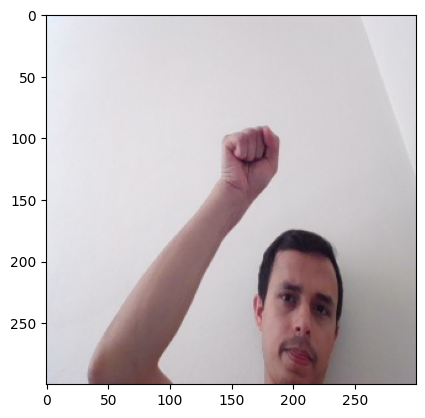

In [ ]:
newPath = './captured_images'
show_info(train_custom,'Train',newPath)

Devtest Dataset Number of image per class is {'paper': 25, 'rock': 25, 'scissors': 25}
The Image shape is (300, 300, 3)


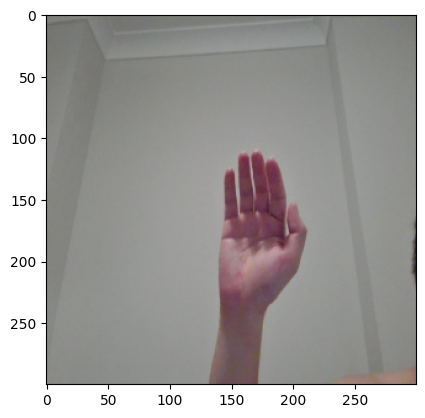

In [ ]:
show_info(devtest_custom,'Devtest',newPath)

Test Dataset Number of image per class is {'paper': 25, 'scissors': 25, 'rock': 25}
The Image shape is (300, 300, 3)


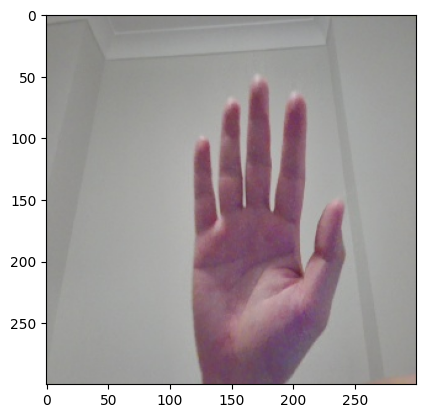

In [ ]:
show_info(test_custom,'Test',newPath)

Significant differences:

- Lighting and Shadows : New images often contain inconsistent lighting and shadows
- Background : The kaggle dataset typically had clean, uniform backgrounds
- Orientation : The orientation, angle, and position of hands may vary greatly in captured images. If the model was trained primarily on centered and consistently-angled hands, it might struggle with these variations.
- Image Resolution and Blur: Captured images have lower resolution and motion blur

Potential Issues:

- Overfitting to Clean Data : If the model was trained on a clean and consistent dataset, it may fail to generalize to more realistic, variable inputs like those in the captured set.
- Feature Mismatch : The model may prioritize features that don't generalize well to new data.
- Class Imbalance : If certain gestures were underrepresented in the training data, the model might be biased toward overrepresented classes.

### Fine Tuning 

In [ ]:
class ImageFineTunedDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    self.data = pd.read_csv(csv_file)
    self.label_map = {'paper': 0, 'rock': 1, 'scissors': 2}
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getdefaultitem__(self, ix):
    file_name = self.data.iloc[ix, 0]
    label = self.data.iloc[ix, 1]

    return file_name, label

  def __getitem__(self, ix):
    file_name = self.data.iloc[ix, 0]
    label = self.data.iloc[ix, 1]
    label = self.label_map[label]
    
    image = cv2.imread('./captured_images/' + file_name)
    image = cv2.resize(image, (100, 100)) 
    image = torch.tensor(image).float() / 255
    image = image.permute(2, 0, 1)
    
    if self.transform:
      image = self.transform(image)
            
    return image.to(device).float(), \
      torch.tensor(label).long().to(device)
  
# Transform
transform = transforms.Compose([
  transforms.ColorJitter(brightness=0.1, contrast=0.2),
  transforms.Normalize((0.5), (0.5))
])


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [ ]:
test_custom = ImageFineTunedDataset("test_custom.csv")
ft_test_custom = ImageFineTunedDataset("test_custom.csv", transform=transform)
custom_test_dl = DataLoader(test_custom, batch_size=32, shuffle=False)
custom_ft_test_dl = DataLoader(ft_test_custom, batch_size=32, shuffle=False)

custom_accuracy = evaluate_model(mobilenet, custom_test_dl)

print(f"Accuracy of MobileNet on new test set: {custom_accuracy:.3f}")

custom_accuracy = evaluate_model(mobilenet, custom_ft_test_dl)

print(f"Accuracy of MobileNet on new test set with fine tuning: {custom_accuracy:.3f}")

Accuracy of MobileNet on new test set: 0.373
Accuracy of MobileNet on new test set with fine tuning: 0.320


In [ ]:
mobilenet.transform = transforms.Compose([
  transforms.ColorJitter(brightness=0.1, contrast=0.2),
  transforms.ToTensor(),       
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


custom_accuracy = evaluate_model(mobilenet, new_test_dl)

print(f"Accuracy of MobileNet on fine tuned to test loader: {custom_accuracy:.3f}")

Accuracy of MobileNet on fine tuned to test loader: 0.954


Answering the A2 Question 3
1. Accuracy of MobileNet on new test set: 0.373 - The model is still using features learned from ImageNet, which may not align well with the characteristics of the new test set. Therefore, the accuracy is relatively low.
2. Accuracy of MobileNet on new test set with fine tuning: 0.320 - The slight decrement in accuracy (0. after fine-tuning shows that the MobileNet model has not benefited from the fine-tuning process and  still faces challenges in fully adapting to the new data.
3. Accuracy of MobileNet on fine tuned to test loader: 0.954 - The accuracy of Fine Tuned MobileNet to the first dataset is 0.954 shows how Overfitting it is to the Original Test Set. 